# <u> **Energy Consumption Time Series Analaysis** </u>

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [67]:
from google.colab import drive
drive.mount('/content/drive')

import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Energy_Time_Series_Analysis'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

df = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, 'PJME_hourly.csv'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['PJME_hourly.csv', 'XenergY.ipynb']


----
##<center><b>Data Preprocessing</b></center>
----

In [68]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

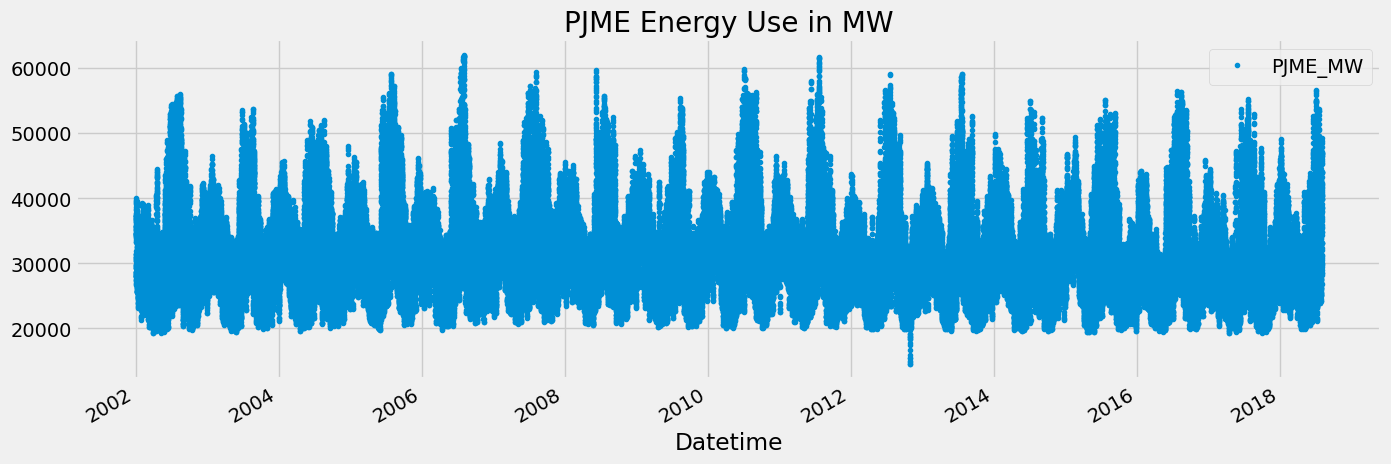

In [69]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title='PJME Energy Use in MW')
plt.show()

----
##<center><b>Exploratory Data Analysis (EDA)</b></center>
----

In [70]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [71]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [72]:
# Empty Entries check
df.isnull().sum()

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [73]:
# Duplicate Entry check
df[df.duplicated()].shape[0]

0

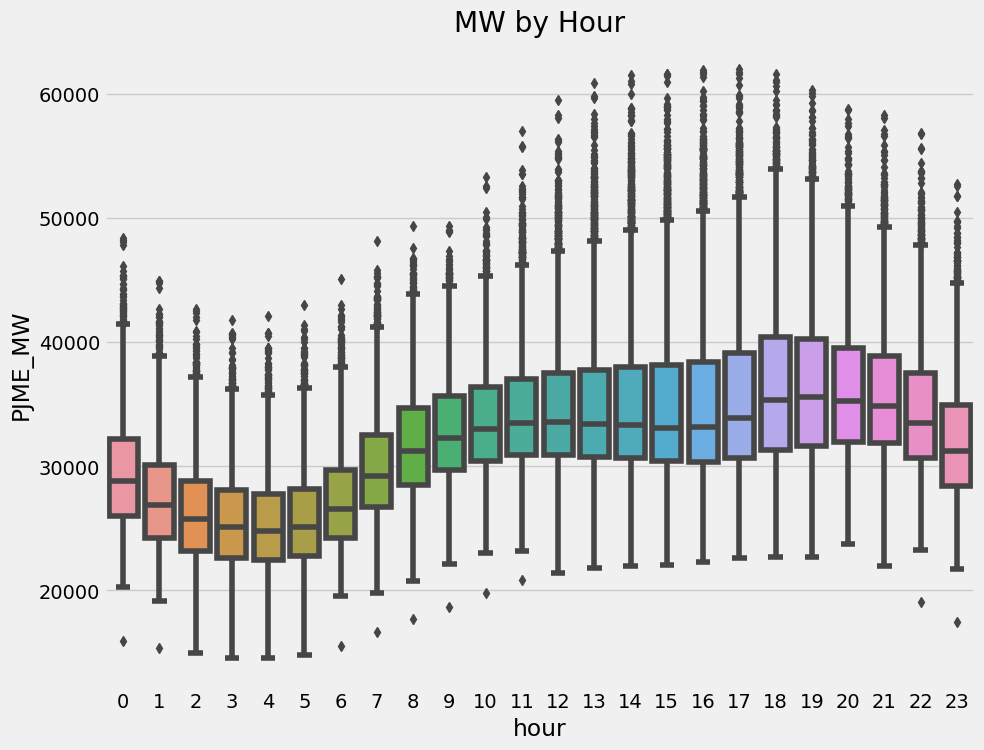

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

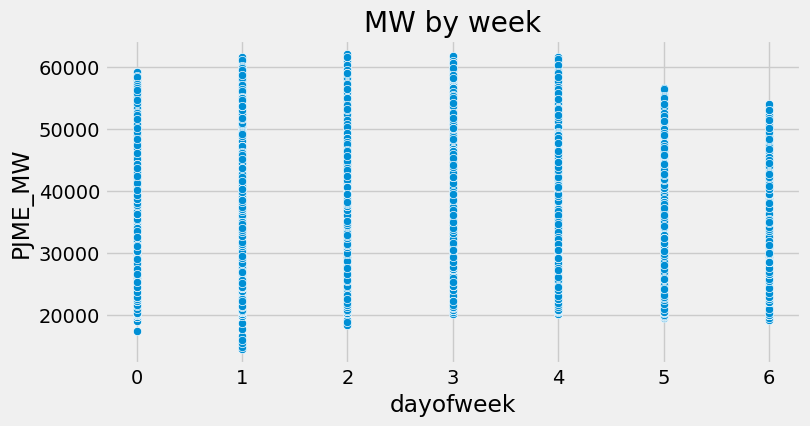

In [75]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(data=df, x='dayofweek', y='PJME_MW')
ax.set_title('MW by week')
plt.show()

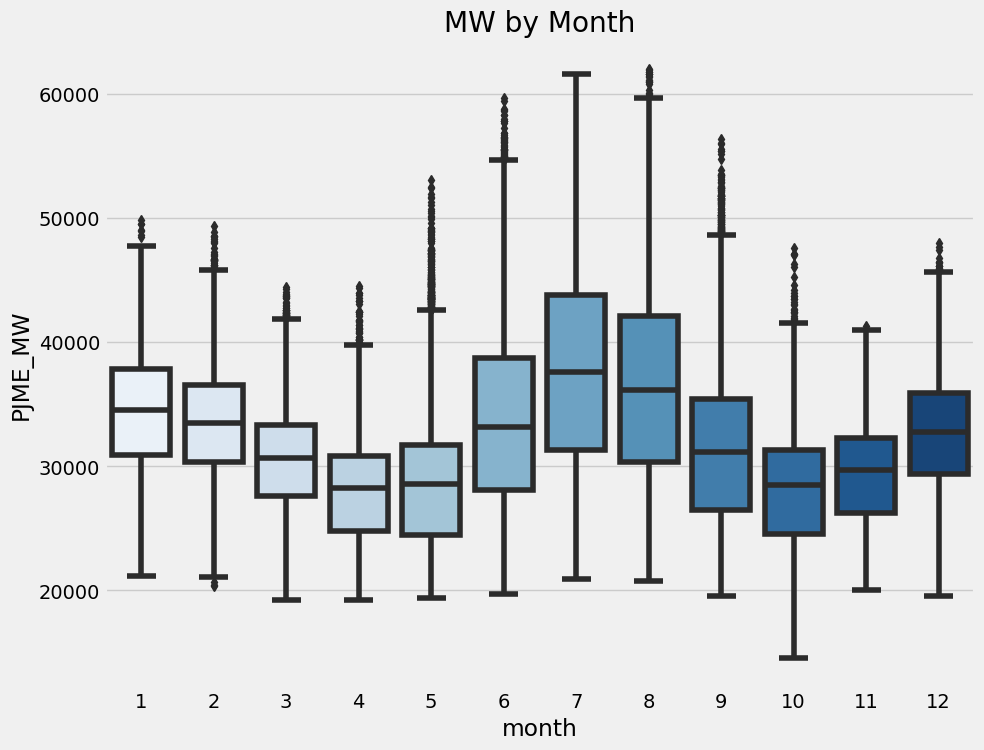

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

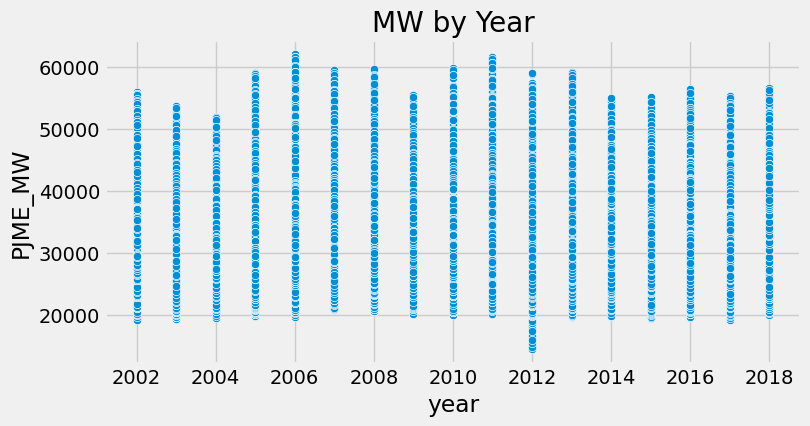

In [77]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(data=df, x='year', y='PJME_MW')
ax.set_title('MW by Year')
plt.show()

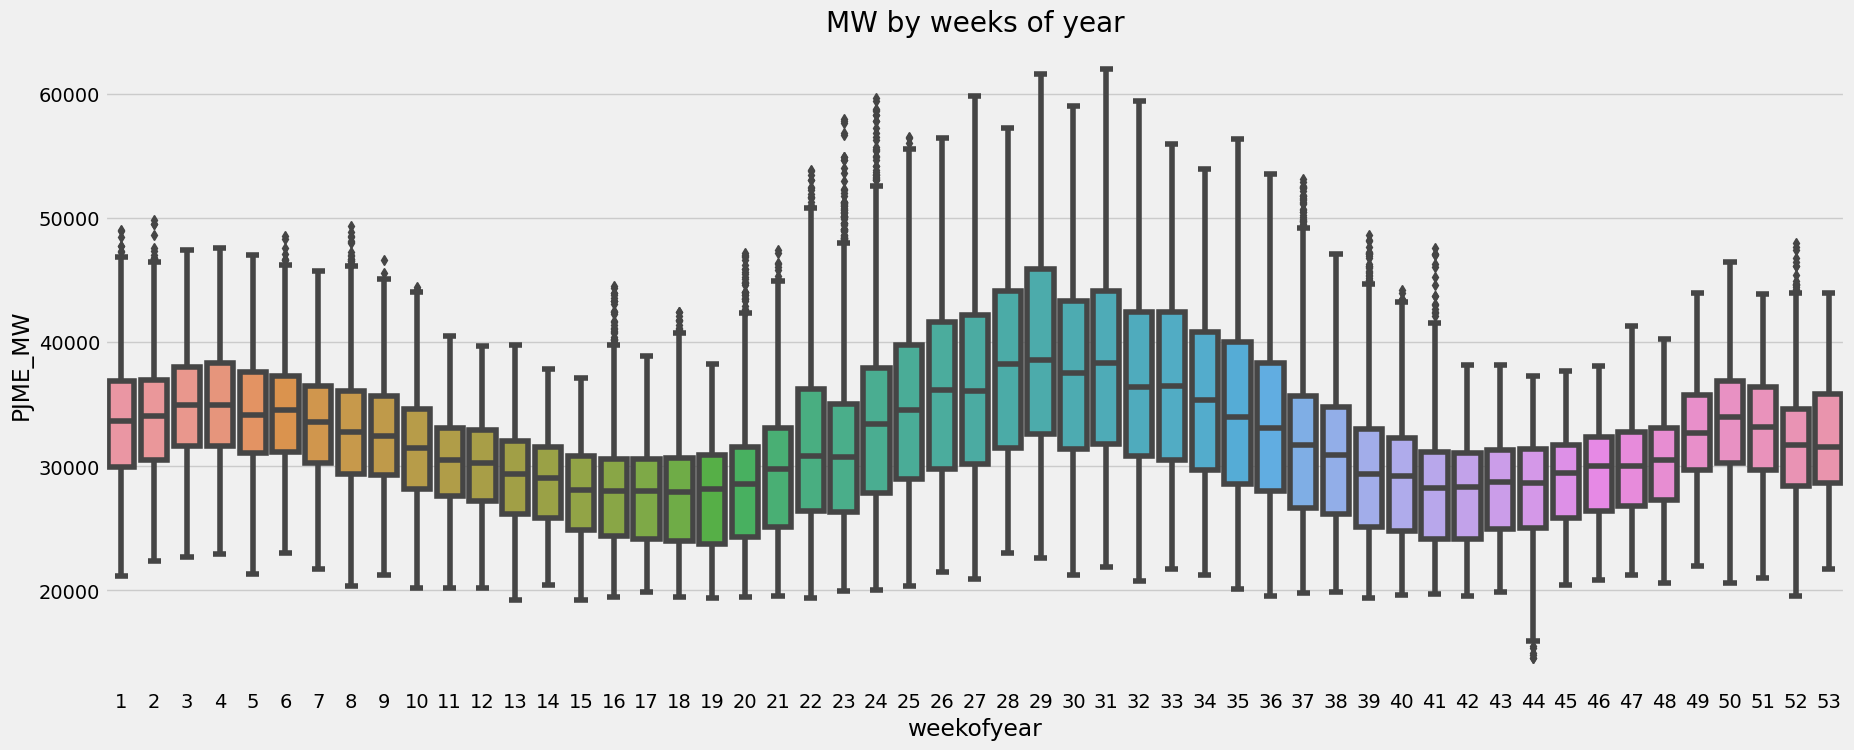

In [78]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(data=df, x='weekofyear', y='PJME_MW')
ax.set_title('MW by weeks of year')
plt.show()

----
##<center><b>Feature Engineering</b></center>
----

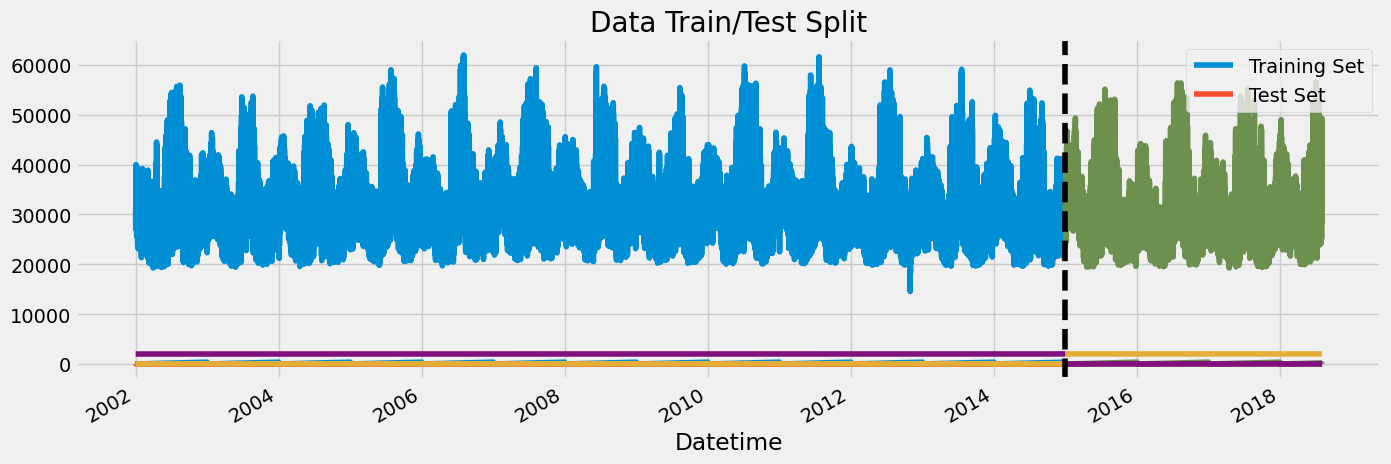

In [79]:
train, test = df.loc[df.index < '01-01-2015'], df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

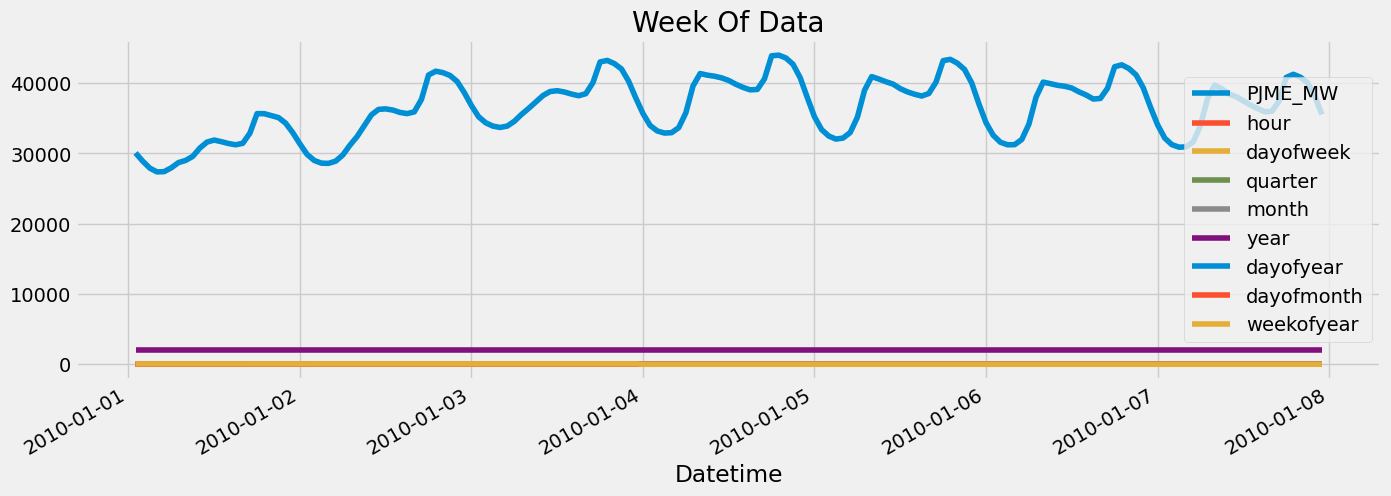

In [80]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

----
##<center><b> Model Building </b></center>
----

In [81]:
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']

X_train, y_train, X_test, y_test = train[features], train['PJME_MW'], test[features], test['PJME_MW']

In [82]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

----
##<center><b> Feature Importance </b></center>
----

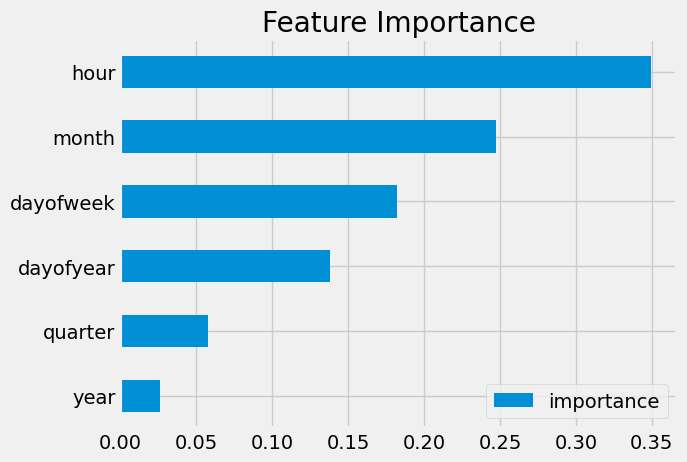

In [83]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

----
##<center><b> Testset Forecasting </b></center>
----

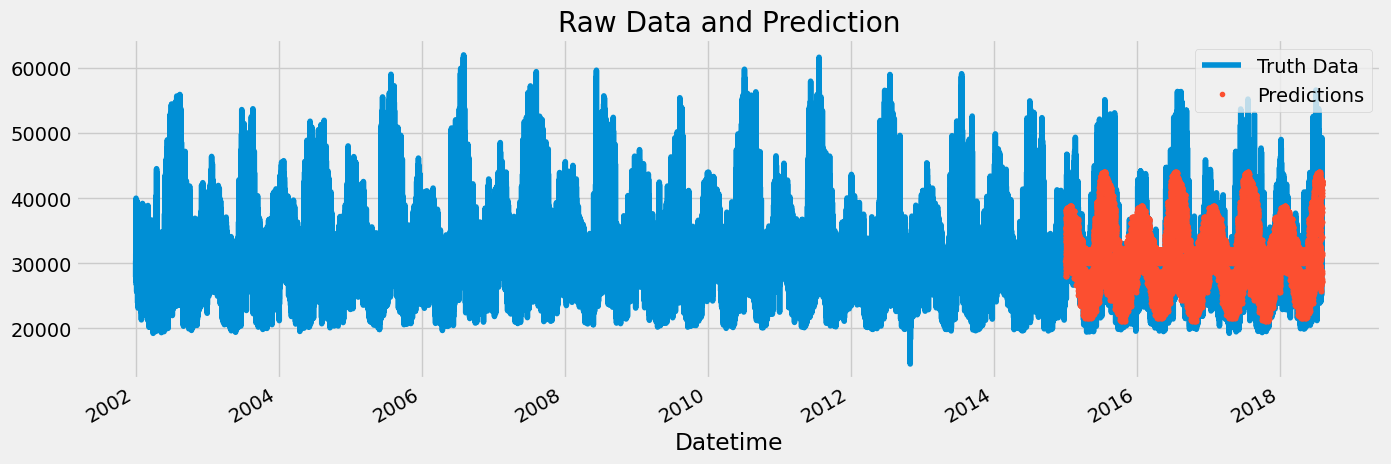

In [84]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

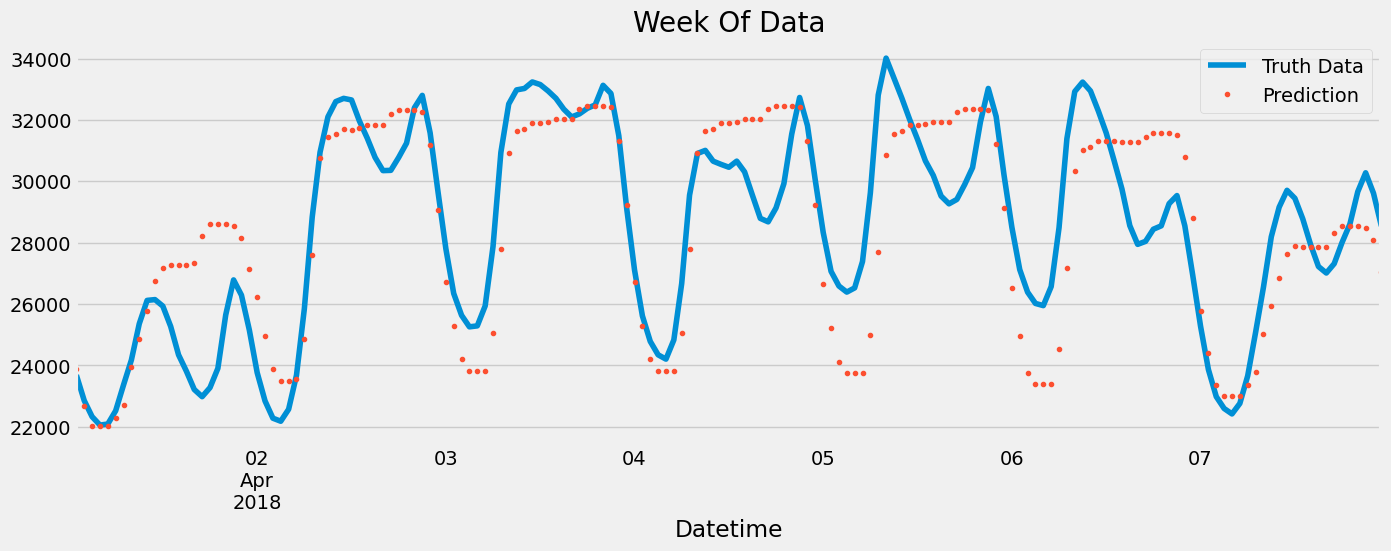

In [85]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

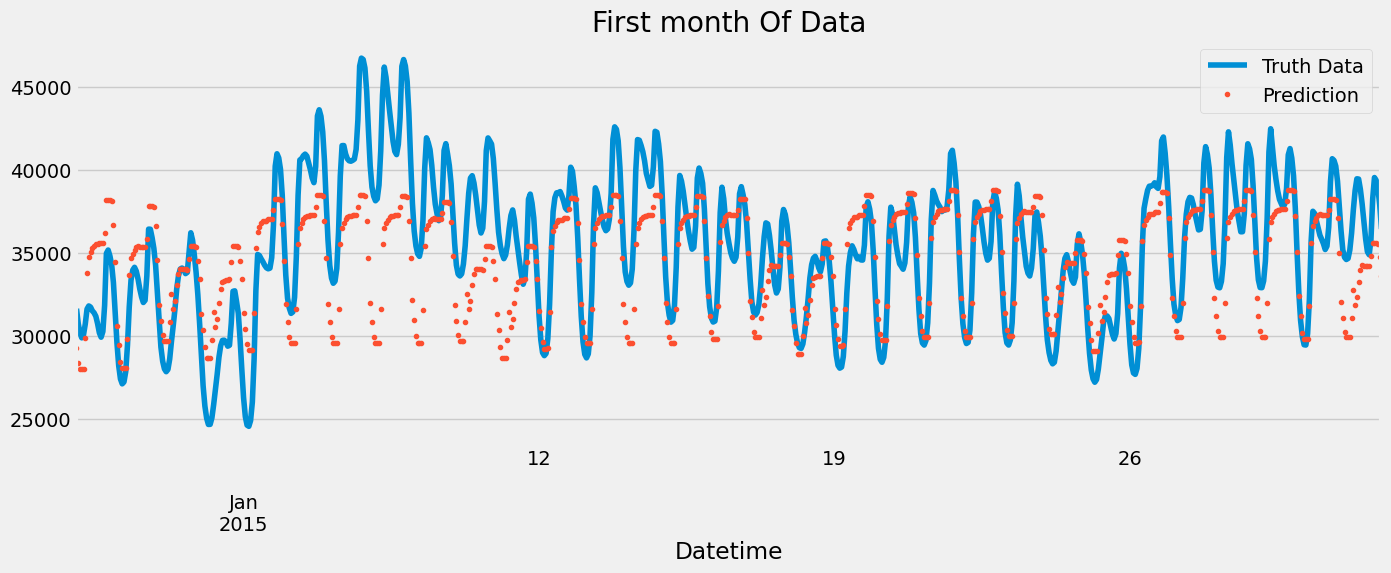

In [86]:
ax = df.loc[(df.index > '01-01-2015') & (df.index < '02-01-2015')]['PJME_MW'].plot(figsize=(15, 5), title='First month Of Data')
df.loc[(df.index > '01-01-2015') & (df.index < '02-01-2015')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

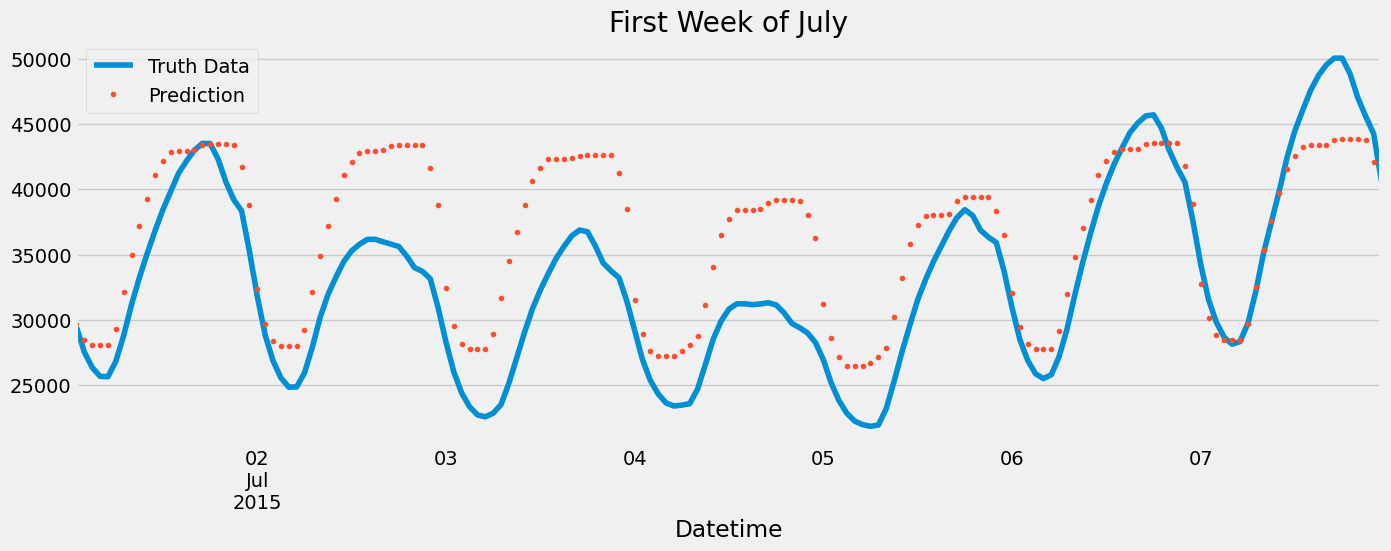

In [87]:
ax = df.loc[(df.index > '07-01-2015') & (df.index < '07-08-2015')]['PJME_MW'].plot(figsize=(15, 5), title='First Week of July')
df.loc[(df.index > '07-01-2015') & (df.index < '07-08-2015')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

----
##<center><b> Model Evaluation </b></center>
----

In [88]:
mse = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {mse:0.2f}')

RMSE Score on Test set: 3726.80


In [89]:
mae = mean_absolute_error(y_true=test['PJME_MW'], y_pred=test['prediction'])
print(f'MAE Score on Test set: {mae:0.2f}')

MAE Score on Test set: 2902.29


In [90]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return print(f"{np.mean(np.abs((y_true - y_pred) / y_true)) * 100:0.2f}% mean absolute error")

mean_absolute_percentage_error(y_true=test['PJME_MW'], y_pred=test['prediction'])

9.16% mean absolute error


----
##<center><b> Error Analysis </b></center>
----

In [91]:
test['error'] = test['PJME_MW'] - test['prediction']
test['abs_error'] = test['error'].apply(np.abs)

In [92]:
error_by_day = test.groupby(['year', 'month', 'dayofmonth']).mean(numeric_only=True)[['PJME_MW', 'prediction', 'error', 'abs_error']]

**Best absolute forcasted days:**

In [93]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

,,,PJME_MW,prediction,error,abs_error
year,month,dayofmonth,,,,
2017,10,24,28657.416667,28647.845703,9.569661,322.958008
2015,10,28,28500.958333,28647.845703,-146.888672,426.451335
2016,10,27,28611.166667,28624.937500,-13.770020,543.167155
2015,5,6,28948.666667,29186.742188,-238.074870,556.749674
2017,10,15,25363.250000,25377.044922,-13.793945,569.468262
2018,5,16,29049.833333,29223.876953,-174.043457,569.951009
2015,11,6,28024.250000,28557.384766,-533.135986,678.310140
2017,4,7,28840.250000,28944.250000,-104.000326,687.475911
2016,12,29,32506.833333,32603.695312,-96.862305,706.143392


The best predicted days seem to be a lot of october (not many holidays and mild weather), same weather reasoning can apply for the Spring months of April and May.  

**Worst Overforcasted days:**

In [94]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW    prediction        error    abs_error
year month dayofmonth                                                      
2016 7     4           28399.958333  37457.519531 -9057.563395  9057.563395
2015 12    25          24466.083333  32122.048828 -7655.966553  7655.966553
2017 9     4           26552.416667  33866.453125 -7314.036458  7314.036458
     5     29          24528.416667  31838.228516 -7309.812256  7309.812256
     6     8           26943.791667  34077.355469 -7133.564941  7133.564941
     2     24          26445.083333  33508.011719 -7062.926839  7062.926839
2015 7     3           30024.875000  37026.511719 -7001.635417  7001.635417
2016 6     9           27318.083333  34296.191406 -6978.107096  6978.107096
2017 9     2           24201.458333  30931.078125 -6729.620850  6729.620850
2018 6     11          27287.958333  33986.582031 -6698.625977  6698.625977

We can see, 1st worst day: 4th July 2016 -> Holiday, 2nd worst day: 25th December 2015 -> Christmas and 4th worst day: 29th May 2017 -> Holiday

We should consider holidays in our analysis.

**Worst underforcasted days:**

In [95]:
error_by_day.sort_values('error', ascending=False).head(10)

PJME_MW    prediction         error     abs_error
year month dayofmonth                                                        
2016 8     13          45185.833333  32306.349609  12879.484619  12879.484619
           14          44427.333333  31654.445312  12772.887207  12772.887207
2015 2     20          44694.041667  33508.011719  11186.031494  11186.031494
2016 9     9           43836.958333  32870.445312  10966.513102  10966.513102
           10          40996.166667  30107.064453  10889.102214  10889.102214
2018 1     6           43565.750000  32922.773438  10642.975830  10642.975830
2016 8     12          45724.708333  35683.535156  10041.172689  10041.172689
2015 2     21          40918.666667  30930.498047   9988.168783   9988.168783
           16          43949.500000  34048.691406   9900.809326   9900.809326
2018 1     7           42159.708333  32307.138672   9852.571370   9852.571370